In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras import Sequential
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import datetime
import textblob

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model

In [ ]:
#!tar -xvf '/content/drive/MyDrive/test_rosatom/aclImdb_v1.tar.gz' -C '/content/drive/MyDrive/test_rosatom'

In [ ]:
# train = pd.DataFrame({'text':[], 'mark':[], 'label':[]})
# test = pd.DataFrame({'text':[], 'mark':[], 'label':[]})
# for filepath, dir, file in os.walk('/content/drive/MyDrive/test_rosatom/aclImdb'):
#   if filepath.split('/')[-2] == 'train' and filepath.split('/')[-1] == 'pos':
#       for f in file:
#         with open(filepath + '/' + f, 'r') as item:
#           new_row = {'text': item.read(), 'mark': int(f.split('_')[1][0]), 'label': 1}
#           train.loc[len(train)] = new_row

#   if filepath.split('/')[-2] == 'train' and filepath.split('/')[-1] == 'neg':
#     for f in file:
#       with open(filepath + '/' + f, 'r') as item:
#         new_row = {'text': item.read(), 'mark': int(f.split('_')[1][0]), 'label': 0}
#         train.loc[len(train)] = new_row

#   if filepath.split('/')[-2] == 'test' and filepath.split('/')[-1] == 'pos':

#     for f in file:
#       with open(filepath + '/' + f, 'r') as item:
#         new_row = {'text': item.read(), 'mark': int(f.split('_')[1][0]), 'label': 1}
#         test.loc[len(test)] = new_row

#   if filepath.split('/')[-2] == 'test' and filepath.split('/')[-1] == 'neg':
#     for f in file:
#       with open(filepath + '/' + f, 'r') as item:
#         new_row = {'text': item.read(), 'mark': int(f.split('_')[1][0]), 'label': 0}
#         test.loc[len(test)] = new_row

# train.to_csv('/content/drive/MyDrive/test_rosatom/train.csv')
# test.to_csv('/content/drive/MyDrive/test_rosatom/test.csv')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/test_rosatom/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test_rosatom/test.csv')

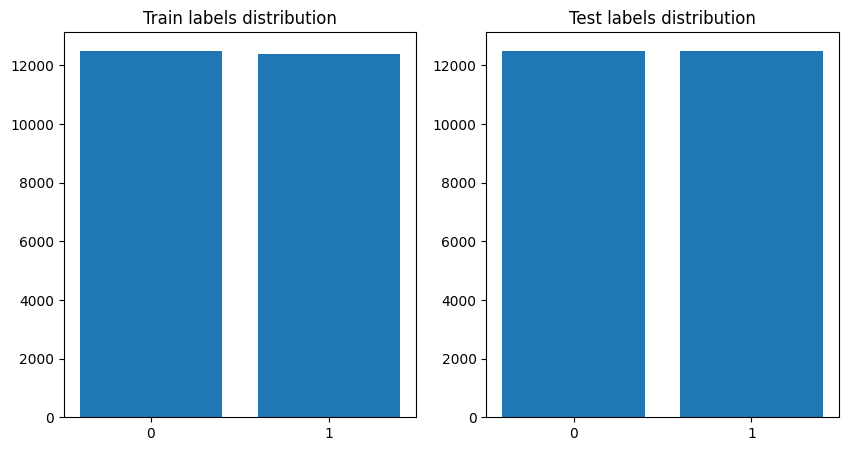

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('Train labels distribution')
ax1.bar(train.label.value_counts().index, train.label.value_counts())
ax1.set_xticks([0, 1])

ax2.set_title('Test labels distribution')
ax2.bar(test.label.value_counts().index, test.label.value_counts())
ax2.set_xticks([0, 1]);

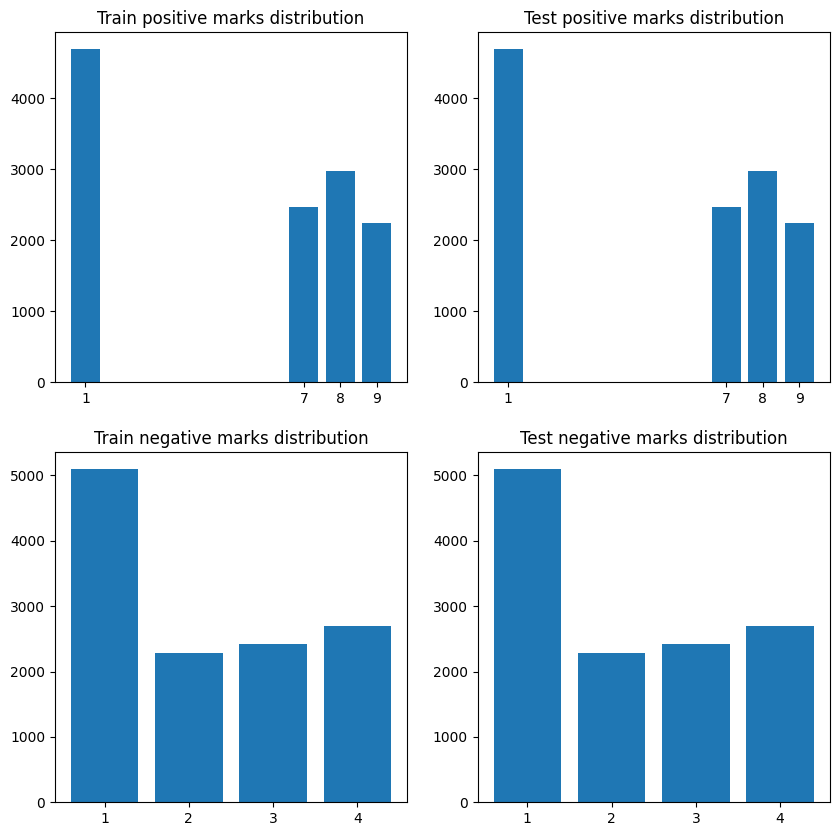

In [ ]:
train_pos = train.loc[train.label == 1]
train_neg = train.loc[train.label == 0]
test_pos = train.loc[train.label == 1]
test_neg = train.loc[train.label == 0]


fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].set_title('Train positive marks distribution')
ax[0,0].bar(train_pos.mark.value_counts().sort_index().index, train_pos.mark.value_counts().sort_index())
ax[0,0].set_xticks(train_pos.mark.value_counts().sort_index().index.to_list())

ax[0,1].set_title('Test positive marks distribution')
ax[0,1].bar(test_pos.mark.value_counts().sort_index().index, test_pos.mark.value_counts().sort_index())
ax[0,1].set_xticks(test_pos.mark.value_counts().sort_index().index.to_list())

ax[1,0].set_title('Train negative marks distribution')
ax[1,0].bar(train_neg.mark.value_counts().sort_index().index, train_neg.mark.value_counts().sort_index())
ax[1,0].set_xticks(train_neg.mark.value_counts().sort_index().index.to_list())

ax[1,1].set_title('Test negative marks distribution')
ax[1,1].bar(test_neg.mark.value_counts().sort_index().index, test_neg.mark.value_counts().sort_index())
ax[1,1].set_xticks(test_neg.mark.value_counts().sort_index().index.to_list());

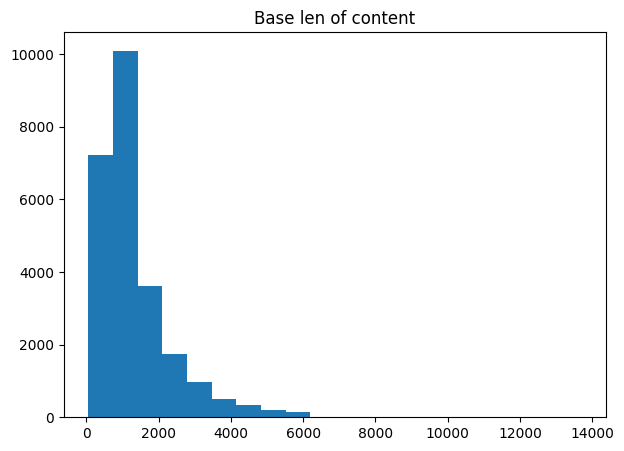

In [ ]:
base_content_len = [len(i) for i in train.text]
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Base len of content')
ax.hist(base_content_len, bins=20);

In [ ]:
train['len'] = [len(i) for i in train.text]
test['len'] = [len(i) for i in test.text]

In [ ]:
train['words_num'] = [len(i.split()) for i in train.text]
test['words_num'] = [len(i.split()) for i in test.text]

In [ ]:
nltk.download('stopwords')
sw = stopwords.words('english')
train['sw_num'] = train.text.apply(lambda x: len([i for i in x.split() if i in sw]))
test['sw_num'] = test.text.apply(lambda x: len([i for i in x.split() if i in sw]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train['punctuation_num'] = train.text.apply(lambda x: len([i for i in x if i in punctuation]))
test['punctuation_num'] = test.text.apply(lambda x: len([i for i in x if i in punctuation]))

In [ ]:
train['avg_word_len'] = train.text.apply(lambda x: sum([len(i) for i in x.split()])/len([len(i) for i in x.split()]))
test['avg_word_len'] = test.text.apply(lambda x: sum([len(i) for i in x.split()])/len([len(i) for i in x.split()]) )

In [ ]:
train['sentence_num'] = train.text.apply(lambda x: len([i for i in x.split('.') ]))
test['sentence_num'] = test.text.apply(lambda x: len([i for i in x.split('.')]))

In [ ]:
train['polarity'] = [textblob.TextBlob(i).sentiment.polarity for i in train.text]
test['polarity'] = [textblob.TextBlob(i).sentiment.polarity for i in test.text]

In [ ]:
train['subjectivity'] = [textblob.TextBlob(i).sentiment.subjectivity for i in train.text]
test['subjectivity'] = [textblob.TextBlob(i).sentiment.subjectivity for i in test.text]

In [ ]:
train['uppercase_words_num'] = train.text.apply(lambda x: len([i for i in x if  i.isupper()]))
test['uppercase_words_num'] = test.text.apply(lambda x: len([i for i in x if i.isupper()]))

In [ ]:
train['unique_words_num'] = [len(set(i.split())) for i in train.text ]
test['unique_words_num'] = [len(set(i.split())) for i in test.text]

In [ ]:
X_train, X_valid, y_train, y_valid  = train_test_split(train, train.loc[:,['label','mark']], test_size=0.25)
X_train_text = X_train.text
X_valid_text = X_valid.text

y_train_class = y_train.label.values
y_train_rating = tf.keras.utils.to_categorical(y_train.mark.values)
y_valid_class = y_valid.label.values
y_valid_rating = tf.keras.utils.to_categorical(y_valid.mark.values)

X_train_csv = X_train.drop(['cleaned_and_removed', 'cleaned_text', 'text', 'mark', 'label', 'Unnamed: 0'], axis=1)
X_valid_csv = X_valid.drop(['cleaned_and_removed', 'cleaned_text','text', 'mark', 'label', 'Unnamed: 0'], axis=1)

X_test_text = test.text
X_test_csv = test.drop(['cleaned_and_removed', 'cleaned_text','text', 'mark', 'label', 'Unnamed: 0'], axis=1)
y_test_class = test.label.values
y_test_rating = test.mark.values

In [ ]:
def standartization(data):
  scaler = MinMaxScaler()
  columns = ['len', 'words_num', 'sw_num', 'punctuation_num',
             'avg_word_len', 'sentence_num', 'unique_words_num',
             'uppercase_words_num']
  data.loc[:, columns] = scaler.fit_transform(data.loc[:, columns])
  return data

In [ ]:
X_train_csv = standartization(X_train_csv)
X_valid_csv = standartization(X_valid_csv)
X_test_csv = standartization(X_test_csv)

In [ ]:
Vectorizer = keras.layers.TextVectorization(max_tokens=10000
                                            ,output_sequence_length=300,
                                            output_mode='int')
Vectorizer.adapt(X_train_text)

In [ ]:
csv_input = keras.layers.Input(shape=X_train_csv.shape[1])
def csv_model(csv_input):
  x = keras.layers.BatchNormalization()(csv_input)
  x = keras.layers.Dense(16,activation="relu")(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(8, activation="relu")(x)
  x = keras.layers.Dropout(0.3)(x)
  return x

In [ ]:
text_input = keras.layers.Input(shape=(1,), dtype='string')
def text_model(text_input):
  x = Vectorizer(text_input)
  x = keras.layers.Embedding(10000, 16, input_length=300)(x)
  x = keras.layers.Dense(16,activation="relu")(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(8, activation="relu")(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Flatten()(x)
  return x


In [ ]:
csv_class = csv_model(csv_input)
text_class = text_model(text_input)
combinedInput_class = keras.layers.concatenate([csv_class, text_class])
class_ = keras.layers.Dense(1, activation="sigmoid", name='class_')(combinedInput_class)

csv_rating = csv_model(csv_input)
text_rating = text_model(text_input)
combinedInput_rating = keras.layers.concatenate([csv_rating, text_rating])
rating = keras.layers.Dense(10, activation="softmax", name='rating')(combinedInput_rating)

model = Model(inputs=[csv_input,text_input],
              outputs=[class_, rating])

model.compile(loss={'class_':'binary_crossentropy', 'rating':'categorical_crossentropy'},
              metrics='accuracy', optimizer='adam')


check_path = '/content/drive/MyDrive/test_rosatom/checkpoints_'+ datetime.datetime.now().strftime("%H%M%S")
#log_path = '/content/drive/MyDrive/test_rosatom/logs_'+ datetime.datetime.now().strftime("%H%M%S")
early = EarlyStopping(monitor='val_class__loss', patience=5)
check = ModelCheckpoint(filepath=check_path, save_best_only=True)
#tensor = TensorBoard(log_dir=log_path, histogram_freq=1)



In [ ]:
model.fit(x=[X_train_csv, X_train_text], y=[y_train_class, y_train_rating],
          epochs=50,
          validation_data=([X_valid_csv,X_valid_text], [y_valid_class, y_valid_rating]),
          callbacks=[early, check],
          batch_size=64)

Epoch 1/50
290/292 [============================>.] - ETA: 0s - loss: 2.3745 - class__loss: 0.6287 - rating_loss: 1.7458 - class__accuracy: 0.6498 - rating_accuracy: 0.3909

292/292 [==============================] - 19s 55ms/step - loss: 2.3730 - class__loss: 0.6283 - rating_loss: 1.7448 - class__accuracy: 0.6504 - rating_accuracy: 0.3914 - val_loss: 2.2042 - val_class__loss: 0.5224 - val_rating_loss: 1.6817 - val_class__accuracy: 0.7470 - val_rating_accuracy: 0.3921
Epoch 2/50
290/292 [============================>.] - ETA: 0s - loss: 2.0197 - class__loss: 0.4010 - rating_loss: 1.6187 - class__accuracy: 0.8224 - rating_accuracy: 0.4003

292/292 [==============================] - 15s 50ms/step - loss: 2.0198 - class__loss: 0.4009 - rating_loss: 1.6189 - class__accuracy: 0.8225 - rating_accuracy: 0.4002 - val_loss: 1.9173 - val_class__loss: 0.3121 - val_rating_loss: 1.6051 - val_class__accuracy: 0.8725 - val_rating_accuracy: 0.3985
Epoch 3/50
291/292 [============================>.] - ETA: 0s - loss: 1.8054 - class__loss: 0.2673 - rating_loss: 1.5381 - class__accuracy: 0.8913 - rating_accuracy: 0.4278

292/292 [==============================] - 15s 50ms/step - loss: 1.8058 - class__loss: 0.2672 - rating_loss: 1.5386 - class__accuracy: 0.8914 - rating_accuracy: 0.4275 - val_loss: 1.8688 - val_class__loss: 0.2872 - val_rating_loss: 1.5817 - val_class__accuracy: 0.8839 - val_rating_accuracy: 0.4036
Epoch 4/50
292/292 [==============================] - 10s 34ms/step - loss: 1.6727 - class__loss: 0.2164 - rating_loss: 1.4563 - class__accuracy: 0.9155 - rating_accuracy: 0.4612 - val_loss: 1.9053 - val_class__loss: 0.2907 - val_rating_loss: 1.6146 - val_class__accuracy: 0.8868 - val_rating_accuracy: 0.4052
Epoch 5/50
292/292 [==============================] - 10s 36ms/step - loss: 1.5693 - class__loss: 0.1836 - rating_loss: 1.3858 - class__accuracy: 0.9290 - rating_accuracy: 0.4903 - val_loss: 1.9108 - val_class__loss: 0.3050 - val_rating_loss: 1.6058 - val_class__accuracy: 0.8859 - val_rating_accuracy: 0.4051
Epoch 6/50
292/292 [==============================] - 10s 33ms/step - loss: 1.477

In [ ]:
class_preds, rating_preds = model.predict([X_test_csv, X_test_text])

782/782 [==============================] - 5s 6ms/step


In [ ]:
print(classification_report(y_test_class, np.where(class_preds > 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85     12500
           1       0.83      0.88      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [ ]:
pr = np.argmax(rating_preds, axis=1)
print(classification_report(y_test_rating, pr))

              precision    recall  f1-score   support

           1       0.49      0.81      0.61     10021
           2       0.19      0.06      0.09      2302
           3       0.22      0.06      0.09      2541
           4       0.24      0.22      0.23      2635
           7       0.24      0.15      0.18      2307
           8       0.23      0.20      0.21      2850
           9       0.17      0.06      0.08      2344

    accuracy                           0.40     25000
   macro avg       0.25      0.22      0.21     25000
weighted avg       0.33      0.40      0.34     25000



In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/test_rosatom/checkpoints_123232__')

In [ ]:
cls, rat = loaded_model.predict([X_test_csv,X_test_text])

781/781 [==============================] - 7s 8ms/step


In [ ]:
print(classification_report(y_test_class, np.where(cls > 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     12493
           1       0.83      0.91      0.87     12495

    accuracy                           0.86     24988
   macro avg       0.86      0.86      0.86     24988
weighted avg       0.86      0.86      0.86     24988



In [ ]:
pr = np.argmax(rat, axis=1)
print(classification_report(y_test_rating, pr))

              precision    recall  f1-score   support

           1       0.46      0.90      0.61     10017
           2       0.22      0.00      0.00      2297
           3       0.22      0.03      0.05      2541
           4       0.24      0.16      0.19      2635
           7       0.25      0.15      0.19      2306
           8       0.24      0.13      0.17      2849
           9       0.17      0.02      0.04      2343

    accuracy                           0.41     24988
   macro avg       0.26      0.20      0.18     24988
weighted avg       0.32      0.41      0.31     24988



In [3]:
!pip3 freeze > /content/drive/MyDrive/test_rosatom/requirements.txt